In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


This is shape of training data:  (1460, 81)
This is shape of test data:  (1459, 80)
Missing values are:  Id               0
TotalBsmtSF      0
Heating          0
SaleCondition    0
CentralAir       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
SaleType         0
YrSold           0
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<function matplotlib.pyplot.show(close=None, block=None)>

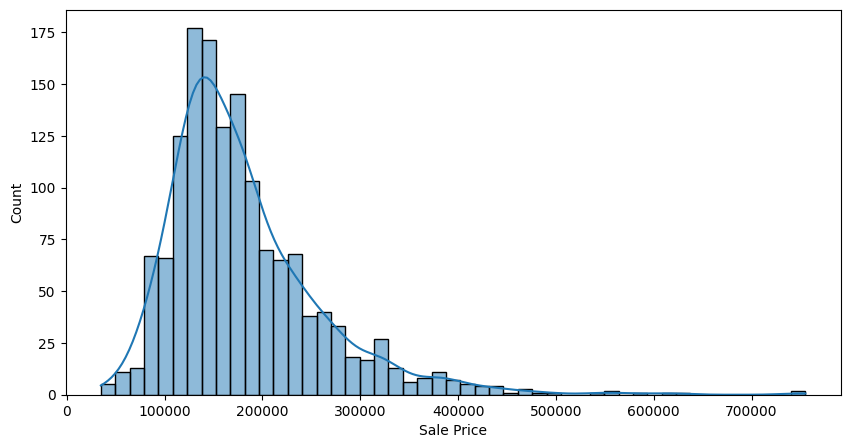

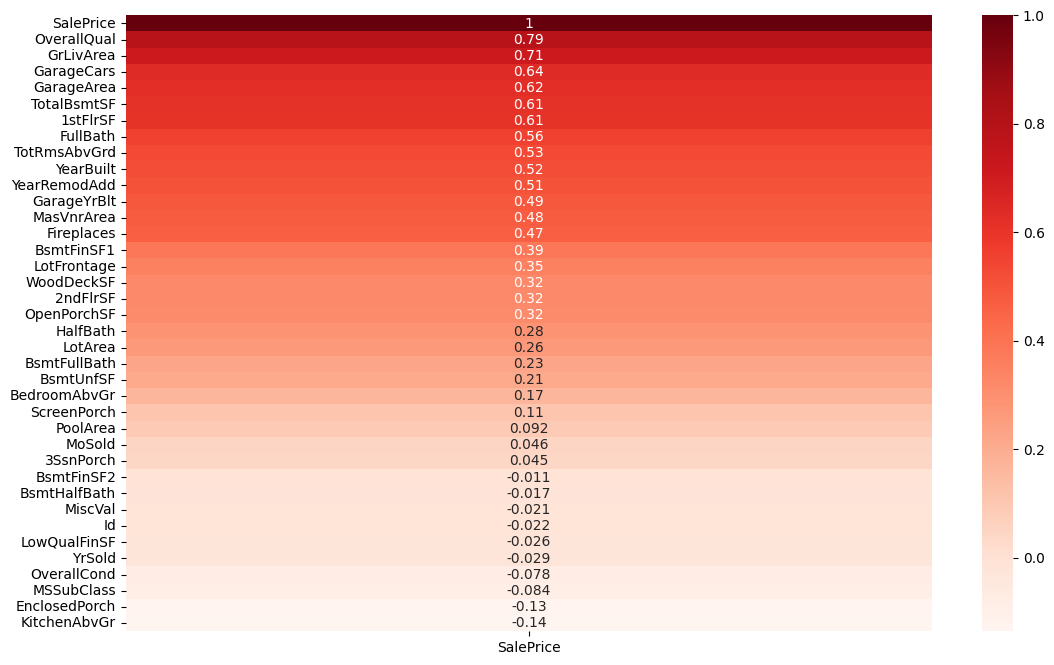

In [2]:
#loading data
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

#finding shape of data
print("This is shape of training data: ", train.shape)
print("This is shape of test data: ", test.shape)

#Check if it contains missing values
missing = train.isnull().sum().sort_values().head(20)
print("Missing values are: ",missing)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(train["SalePrice"],kde = True)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show

plt.figure(figsize=(13,8))
corr = train.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending=False)
sns.heatmap(corr,annot=True,cmap="Reds")
plt.show

In [3]:
#from the above heatmap we can figure out that OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF are the best features
test_ids = test["Id"].copy()
train_labels = train['SalePrice'].copy()

# Combine train and test data for preprocessing
all_data = pd.concat([train.drop('SalePrice', axis=1), test], ignore_index=True)

none_cols = [
    'Alley', 
    'PoolQC', 
    'Fence', 
    'MiscFeature', 
    'FireplaceQu',
    'GarageType',  
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'BsmtQual',  
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'MasVnrType'
]
all_data[none_cols] = all_data[none_cols].fillna('None')

zero_cols=[
    'GarageYrBlt' ,
    'GarageArea',
    'GarageCars' ,
    'BsmtFinSF1' ,
    'BsmtFinSF2' ,
    'BsmtUnfSF' ,
    'TotalBsmtSF' ,
    'BsmtFullBath' ,
    'BsmtHalfBath' ,
    'MasVnrArea'
]

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))  # Lot frontage depends on neighborhood
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')  # Most common value
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data[zero_cols] = all_data[zero_cols].fillna(0)
all_data['TotalSF'] = (all_data['TotalBsmtSF']+ all_data['1stFlrSF']+ all_data['2ndFlrSF'])

all_data['HouseAge'] = all_data['YrSold']-all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']

all_data['TotalBath'] = (all_data['FullBath'] 
                         + 0.5 * all_data['HalfBath'] 
                         + all_data['BsmtFullBath'] 
                         + 0.5 * all_data['BsmtHalfBath'])
for feat in ['PoolArea', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'Fireplaces']:
    all_data[f'Has{feat}'] = (all_data[feat] > 0).astype(int)

all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)


quality_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
poolqc_map = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
bsmt_exposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmt_fintype_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
ordinal_maps = {
    'ExterQual': quality_map,
    'ExterCond': quality_map,
    'BsmtQual': quality_map,
    'BsmtCond': quality_map,
    'HeatingQC': quality_map,
    'KitchenQual': quality_map,
    'FireplaceQu': quality_map,
    'GarageQual': quality_map,
    'GarageCond': quality_map,
    'PoolQC': poolqc_map,
    'BsmtExposure': bsmt_exposure_map,
    'BsmtFinType1': bsmt_fintype_map,
    'BsmtFinType2': bsmt_fintype_map
}
for col, mapping in ordinal_maps.items():
    all_data[col] = all_data[col].map(mapping).fillna(0).astype(int)

all_data['CentralAir'] = (all_data['CentralAir'] == 'Y').astype(int)
all_data['PavedDrive'] = all_data['PavedDrive'].map({'N':0,'P':1,'Y':2}).astype(int)

all_data['LandSlope'] = all_data['LandSlope'].map({'Gtl':2,'Mod':1,'Sev':0})
all_data['LandContour'] = all_data['LandContour'].map({'Lvl':3,'Bnk':2,'HLS':1,'Low':0})
all_data['LotShape'] = all_data['LotShape'].map({'Reg':4,'IR1':3,'IR2':2,'IR3':1})

all_data['Street'] = all_data['Street'].map({'Grvl':0,'Pave':1})

cat_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)

all_data.drop(['Id'], axis=1, inplace=True)
n_train=train.shape[0]
train_processed = all_data.iloc[:n_train].copy()
test_processed = all_data.iloc[n_train:].copy()
train_processed['SalePrice'] = train_labels

# Removing outliers
train_processed = train_processed[train_processed['GrLivArea'] < 4500]
train_processed['SalePrice'] = np.log1p(train_processed['SalePrice'])

print("Processed training set shape:", train_processed.shape)
print("Processed test set shape:", test_processed.shape)

# Verify no missing values remain
assert not all_data.isnull().any().any(), "Missing values detected!"

# Save processed data
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

# features = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","1stFlrSF"]


Processed training set shape: (1458, 234)
Processed test set shape: (1459, 233)


In [8]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Data Preparation
def prep_data():
    X = train_processed.drop('SalePrice',axis=1)
    y = train_processed['SalePrice']
    return train_test_split(
        X,y,test_size=0.2,random_state=1
    )
X_train,X_val,y_train,y_val = prep_data()

# Building Models
def get_models():
    return {
        'Ridge':{
            'model': Ridge(random_state = 1),
            'params': {'alpha':[0.1,1,10]},
            'scaler': StandardScaler()
        },
        'Lasso':{
            'model': Lasso(random_state=1,max_iter = 25000),
            'params': {'alpha': [0.1,1,10]},
            'scaler': StandardScaler()
        },
        'RandomForest':{
            'model': RandomForestRegressor(random_state = 1),
            'params': {'n_estimators': [150, 250]},
            'scaler': None
        },
        'GradientBoost':{
            'model': GradientBoostingRegressor(random_state=1),
            'params':{'n_estimators':[150,250],'learning_rate': [0.01, 0.05, 0.1]},
            'scaler':None
        },
        'XGBoost':{
            'model': XGBRegressor(random_state=1),
            'params': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1]},
            'scaler': None
        }
    }

# Model Training
def train_and_eval(models):
    results={}
    for name, config in models.items():
        print(f"Model being trained is {name}")
        
        if config['scaler']:
            model = Pipeline([
                ('scaler', config['scaler']),
                ('model', config['model'])
            ])
            param_grid = {f'model__{k}': v for k,v in config['params'].items()}
        else:
            model = config['model']
            param_grid = config['params']

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            gs = GridSearchCV(
                model,
                param_grid,
                cv=5,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1
            )
            gs.fit(X_train, y_train)
            
            # Evaluate
            val_pred = gs.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            
            results[name] = {
                'model': gs.best_estimator_,
                'rmse': rmse,
                'params': gs.best_params_
            }
            
            print(f"Best params: {gs.best_params_}")
            print(f"Validation RMSE: {rmse:.5f}")
    
    return results

model_configs = get_models()
results = train_and_eval(model_configs)

def select_best_model(results):
    best_name = min(results, key=lambda k: results[k]['rmse'])
    best_model = results[best_name]['model']
    
    print(f"\nBest model: {best_name}")
    print(f"Best RMSE: {results[best_name]['rmse']:.5f}")
    
    return best_model

best_model = select_best_model(results)

def make_predictions(model, test_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.expm1(model.predict(test_data))

predictions = make_predictions(best_model, test_processed)

# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})
submission.to_csv('submission.csv', index=False)

print("\nSubmission created")
print(f"Price range: ${submission['SalePrice'].min():,.0f} - ${submission['SalePrice'].max():,.0f}")

Model being trained is Ridge
Best params: {'model__alpha': 10}
Validation RMSE: 0.12761
Model being trained is Lasso
Best params: {'model__alpha': 0.1}
Validation RMSE: 0.20360
Model being trained is RandomForest
Best params: {'n_estimators': 150}
Validation RMSE: 0.13723
Model being trained is GradientBoost
Best params: {'learning_rate': 0.1, 'n_estimators': 250}
Validation RMSE: 0.12430
Model being trained is XGBoost
Best params: {'learning_rate': 0.1, 'n_estimators': 200}
Validation RMSE: 0.13423

Best model: GradientBoost
Best RMSE: 0.12430

Submission created
Price range: $47,087 - $689,612
